<a href="https://colab.research.google.com/github/victoeywilly/Convolutional_stream/blob/main/detection_streamline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#drive
from google.colab import drive
drive.mount("/content/drive")

!apt install gdal-bin python-gdal python3-gdal 
!pip install rasterio
!apt install python3-rtree 
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
  Cloning git://github.com/geopandas/geopandas.git to /tmp/pip-req-build-prq9s93f
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-prq9s93f


In [2]:
import cv2
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show
import os
import glob
import gc

In [89]:
input_list = glob.glob("/content/drive/MyDrive/Detection_river/sentinel/*.tif")
output_list = glob.glob("/content/drive/MyDrive/Detection_river/label/*.tif")

In [90]:
for i in range(len(input_list)):
  input_image = rio.open(input_list[i]).read()
  print(i, input_image.shape)
  break

0 (16, 995, 975)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


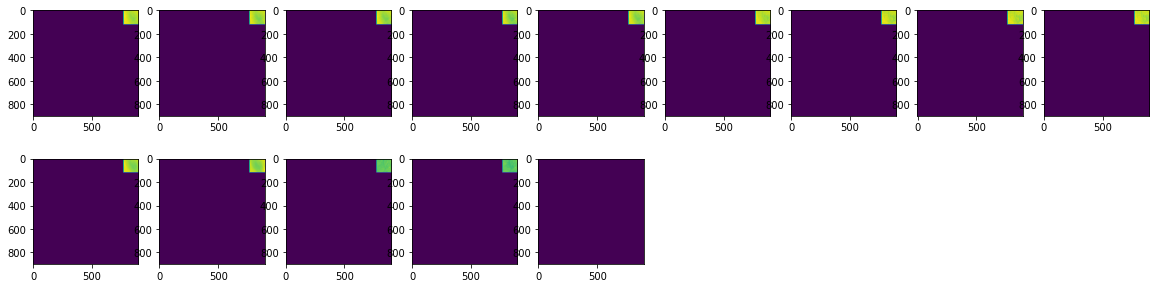

0 all_image_array: (1, 14, 897, 897)


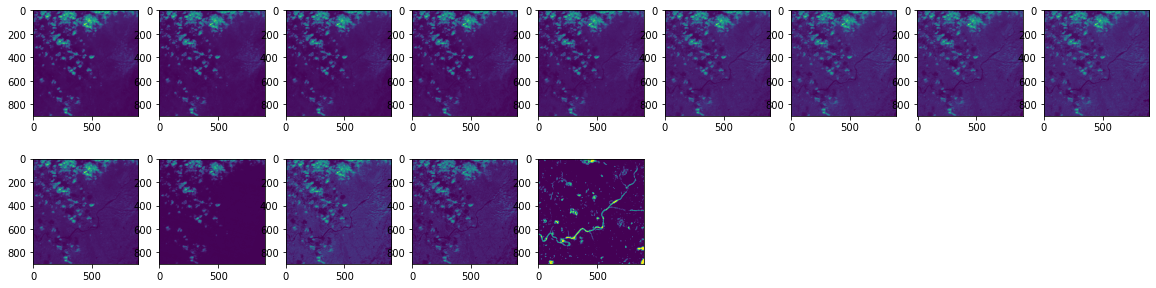

comp: (14, 14, 64, 64)
comp: (11, 14, 64, 64)
comp: (12, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (13, 14, 64, 64)
1 all_image_array: (186, 14, 64, 64)


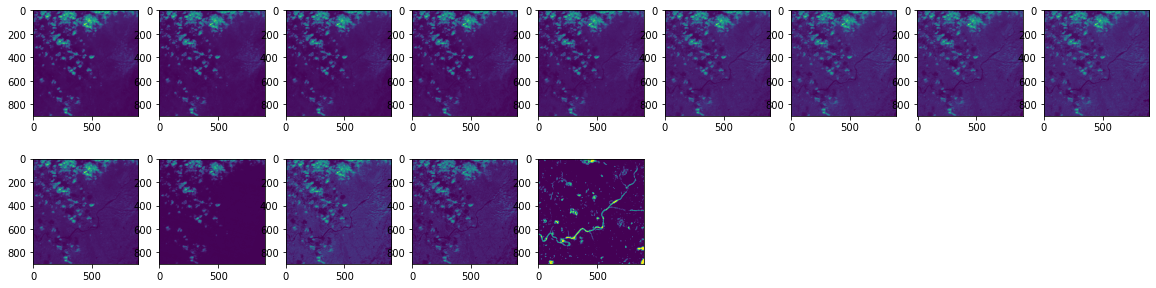

comp: (14, 14, 64, 64)
comp: (11, 14, 64, 64)
comp: (12, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (13, 14, 64, 64)
2 all_image_array: (186, 14, 64, 64)


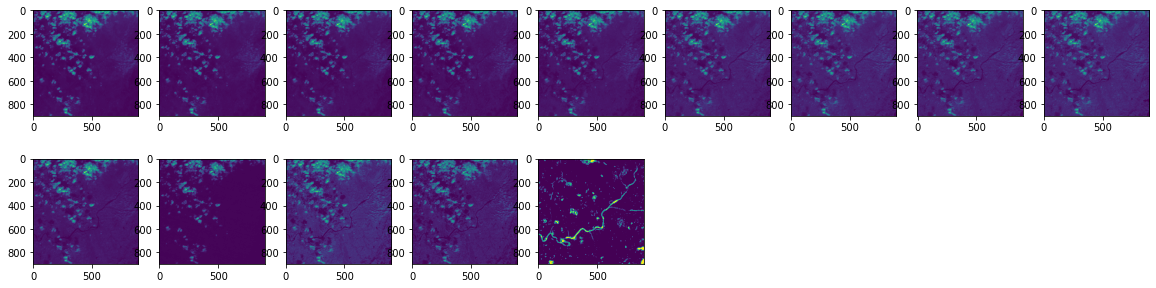

comp: (14, 14, 64, 64)
comp: (11, 14, 64, 64)
comp: (12, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (13, 14, 64, 64)
comp: (14, 14, 64, 64)
comp: (13, 14, 64, 64)
3 all_image_array: (187, 14, 64, 64)


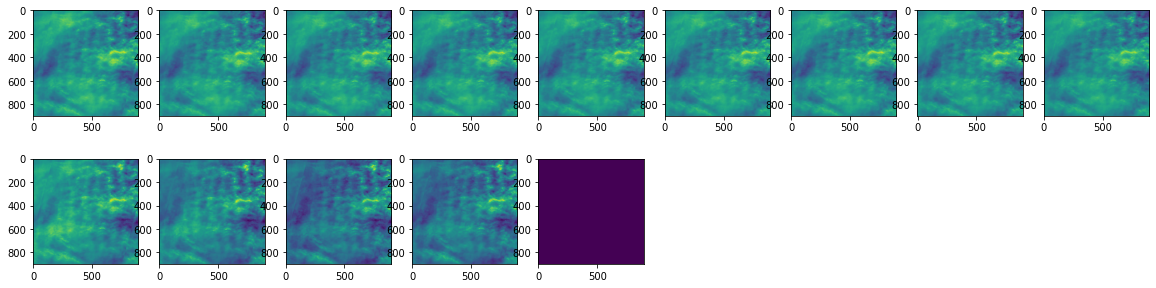

4 all_image_array: (1, 14, 897, 897)


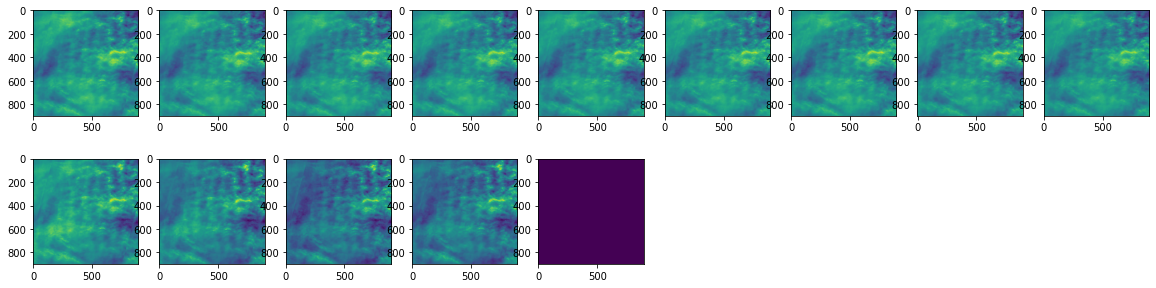

5 all_image_array: (1, 14, 897, 897)


KeyboardInterrupt: ignored

In [91]:
#input_data -- sentinel data based input/ label_data  -- NDWI-based label
all_image_concat = []
for i in range(len(input_list)):
  
  input_image = rio.open(input_list[i])
  input_image_array = input_image.read()
  all_image_array = input_image_array.astype("float32")[:14, :897, :897] # 파장 13까지만 들어가고 14는 NDWI로 대체

  all_image_array = all_image_array.reshape(1, 14, 897, 897)

  band_3 = all_image_array[:, 2, :, :].reshape(-1, 1)
  band_7 = all_image_array[:, 7, :, :].reshape(-1, 1)
  NDWI =  (band_3 - band_7)/(band_3 + band_7)
  NDWI = np.where(NDWI > 0.04, 1, 0)
  NDWI = NDWI.reshape(1, 1, 897, 897)
  all_image_array[:, -1, :, :] = NDWI

  fig = plt.figure(figsize = (20, 5)) 
  rows = 2
  cols = 9
  o = 1
  for n in range(14):
      img = all_image_array[:, n:n+1, :, :].reshape(897, 897)
      ax = fig.add_subplot(rows, cols, o)
      im= ax.imshow(img)
      o += 1
  plt.show()

  rip_size = 64
  rip_x_con = []
  for n_x in range(0, 14):
    rip_x = all_image_array[:, :, rip_size*n_x:rip_size*(n_x+1), :]

    rip_xy_con = []
    for n_y in range(0, 14):
      
      rip_xy = rip_x[:, :, :, n_y*rip_size:rip_size*(n_y+1)]
      rip_xy_eval = np.zeros((1, 14, 50, 50))
      
      if np.sum(rip_xy[:, -1, :, :]) > 0:
        rip_xy_con.append(rip_xy)
    
    if rip_xy_con == []:
      pass
    else:
      rip_xy_con = np.concatenate(rip_xy_con)
      rip_x_con.append(rip_xy_con)
      print("comp:", rip_xy_con.shape)

  if rip_x_con == []:
    pass
  else:
    rip_x_con = np.concatenate(rip_x_con)
    all_image_array = rip_x_con

    all_image_concat.append(all_image_array)

  
  print(i, "all_image_array:", all_image_array.shape) ### Check the extracted image set


all_image_concat = np.concatenate((all_image_concat), axis = 0)
print(all_image_concat.shape)
np.save("/content/drive/MyDrive/Detection_river/dataset_numpy/data_all.npy", all_image_concat)

In [3]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
data_set = torch.Tensor(np.load("/content/drive/MyDrive/Detection_river/dataset_numpy/data_all.npy")).to(device)
mean = []
std = []
for i in range(0, 13):
  mean.append(torch.mean(data_set[:, i:i+1, :, :]))
  std.append(torch.std(data_set[:,i:i+1, :, :]))
  data_set[:, i:i+1, :, :] = (data_set[:, i:i+1, :, :] - torch.mean(data_set[:, i:i+1, :, :]))/torch.std(data_set[:,i:i+1, :, :])

mean = [mean[i].cpu().numpy() for i in range(len(mean))]
std = [std[i].cpu().numpy() for i in range(len(std))]
mean = [float(mean[i]) for i in range(len(mean))]
std = [float(std[i]) for i in range(len(std))]

train_set_x = data_set[:30000, :13, :, :]; train_set_y = data_set[:30000, -1, :, :]
test_set_x = data_set[30000:, :13, :, :]; test_set_y = data_set[30000:, -1, :, :]

del data_set

print("train_shape_x:", train_set_x.shape, "train_shape_y:", train_set_y.shape, "test_shape_x:", test_set_x.shape, "test_shape_y:", test_set_y.shape)
print(torch.max(train_set_x), torch.min(train_set_x))

train_shape_x: torch.Size([30000, 13, 64, 64]) train_shape_y: torch.Size([30000, 64, 64]) test_shape_x: torch.Size([4944, 13, 64, 64]) test_shape_y: torch.Size([4944, 64, 64])
tensor(38.6411, device='cuda:0') tensor(-1.8796, device='cuda:0')


In [6]:
gc.collect()

250

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class STREAMLINER(nn.Module):
    def __init__(self):
        super(STREAMLINER, self).__init__()
        
        def CBRD2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = True):
          layers = []
          layers += [nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding, bias = bias)]
          layers += [nn.BatchNorm2d(num_features = out_channels)]
          layers += [nn.ReLU6()]
          layers += [nn.Dropout(0.3)]
          cbrd = nn.Sequential(*layers)
          return cbrd
        
        #Encoder parts
        self.encoder1_1 = CBRD2d(in_channels = 13, out_channels = 32)
        self.encoder1_2 = CBRD2d(in_channels = 32, out_channels = 32)
        self.pool1 = nn.MaxPool2d(kernel_size = 2)

        self.encoder2_1 = CBRD2d(in_channels = 32, out_channels = 64)
        self.encoder2_2 = CBRD2d(in_channels =64, out_channels = 64)
        self.pool2 = nn.MaxPool2d(kernel_size = 2)

        self.encoder3_1 = CBRD2d(in_channels = 64, out_channels = 128)
        self.encoder3_2 = CBRD2d(in_channels =128, out_channels = 128)
        self.pool3 = nn.MaxPool2d(kernel_size = 2)

        self.encoder4_1 = CBRD2d(in_channels = 128, out_channels = 128)
        self.encoder4_2 = CBRD2d(in_channels =128, out_channels = 256)
        self.pool4 = nn.MaxPool2d(kernel_size = 2)

        # Decoder parts
        self.unpool4 = nn.ConvTranspose2d(in_channels = 256, out_channels = 256, kernel_size = 2, stride = 2, padding = 0, bias = True)
        self.decoder4_2 = CBRD2d(in_channels = 2*256, out_channels = 256)
        self.decoder4_1 = CBRD2d(in_channels = 256, out_channels = 128)

        self.unpool3 = nn.ConvTranspose2d(in_channels = 128, out_channels = 128, kernel_size = 2, stride = 2, padding = 0, bias = True)
        self.decoder3_2 = CBRD2d(in_channels = 2*128, out_channels = 128)
        self.decoder3_1 = CBRD2d(in_channels = 128, out_channels = 64)

        self.unpool2 = nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size = 2, stride = 2, padding = 0, bias = True)
        self.decoder2_2 = CBRD2d(in_channels = 2*64, out_channels = 64)
        self.decoder2_1 = CBRD2d(in_channels = 64, out_channels = 32)

        self.unpool1 = nn.ConvTranspose2d(in_channels = 32, out_channels = 32, kernel_size = 2, stride = 2, padding = 0, bias = True)
        self.decoder1_2 = CBRD2d(in_channels = 2*32, out_channels = 32)
        self.decoder1_1 = CBRD2d(in_channels = 32, out_channels = 8)        

        self.decoder0_1 = CBRD2d(in_channels = 8, out_channels = 1)  

        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU6()


    def forward(self, input):
        #Encoder parts
        encoder1_1 = self.encoder1_1(input)
        encoder1_2 = self.encoder1_2(encoder1_1)
        pool1 = self.pool1(encoder1_2)

        encoder2_1 = self.encoder2_1(pool1)
        encoder2_2 = self.encoder2_2(encoder2_1)
        pool2 = self.pool2(encoder2_2)

        encoder3_1 = self.encoder3_1(pool2)
        encoder3_2 = self.encoder3_2(encoder3_1)
        pool3 = self.pool3(encoder3_2)

        encoder4_1 = self.encoder4_1(pool3)
        encoder4_2 = self.encoder4_2(encoder4_1)
        pool4 = self.pool4(encoder4_2)

        # Decoder parts
        unpool4 = self.unpool4(pool4)
        cat4 = torch.cat((unpool4, encoder4_2), dim = 1)
        decoder4_2 = self.decoder4_2(cat4)
        decoder4_1 = self.decoder4_1(decoder4_2)

        unpool3 = self.unpool3(decoder4_1)
        cat3 = torch.cat((unpool3, encoder3_2), dim = 1)
        decoder3_2 = self.decoder3_2(cat3)
        decoder3_1 = self.decoder3_1(decoder3_2)

        unpool2 = self.unpool2(decoder3_1)
        cat2 = torch.cat((unpool2, encoder2_2), dim = 1)
        decoder2_2 = self.decoder2_2(cat2)
        decoder2_1 = self.decoder2_1(decoder2_2)

        unpool1 = self.unpool1(decoder2_1)
        cat1 = torch.cat((unpool1, encoder1_2), dim = 1)
        decoder1_2 = self.decoder1_2(cat1)
        decoder1_1 = self.decoder1_1(decoder1_2)

        output = self.decoder0_1(decoder1_1)
        output = self.sigmoid(output)

        return output

In [10]:
del data_set

NameError: ignored

In [11]:
gc.collect()

175

In [12]:
model = STREAMLINER().to(device)
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-6, weight_decay=0.001)

n_batches = int(np.ceil(float(len(train_set_y)) / float(400)))
n_batches_test = int(np.ceil(float(len(test_set_y)) / float(400)))
print(n_batches, n_batches_test)

75 13


In [13]:
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

epoch- 0 batch_num- 0 / 75


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch- 0 batch_num- 1 / 75
epoch- 0 batch_num- 2 / 75
epoch- 0 batch_num- 3 / 75
epoch- 0 batch_num- 4 / 75
epoch- 0 batch_num- 5 / 75
epoch- 0 batch_num- 6 / 75
epoch- 0 batch_num- 7 / 75
epoch- 0 batch_num- 8 / 75
epoch- 0 batch_num- 9 / 75
epoch- 0 batch_num- 10 / 75
epoch- 0 batch_num- 11 / 75
epoch- 0 batch_num- 12 / 75
epoch- 0 batch_num- 13 / 75
epoch- 0 batch_num- 14 / 75
epoch- 0 batch_num- 15 / 75
epoch- 0 batch_num- 16 / 75
epoch- 0 batch_num- 17 / 75
epoch- 0 batch_num- 18 / 75
epoch- 0 batch_num- 19 / 75
epoch- 0 batch_num- 20 / 75
epoch- 0 batch_num- 21 / 75
epoch- 0 batch_num- 22 / 75
epoch- 0 batch_num- 23 / 75
epoch- 0 batch_num- 24 / 75
epoch- 0 batch_num- 25 / 75
epoch- 0 batch_num- 26 / 75
epoch- 0 batch_num- 27 / 75
epoch- 0 batch_num- 28 / 75
epoch- 0 batch_num- 29 / 75
epoch- 0 batch_num- 30 / 75
epoch- 0 batch_num- 31 / 75
epoch- 0 batch_num- 32 / 75
epoch- 0 batch_num- 33 / 75
epoch- 0 batch_num- 34 / 75
epoch- 0 batch_num- 35 / 75
epoch- 0 batch_num- 36 / 75
e

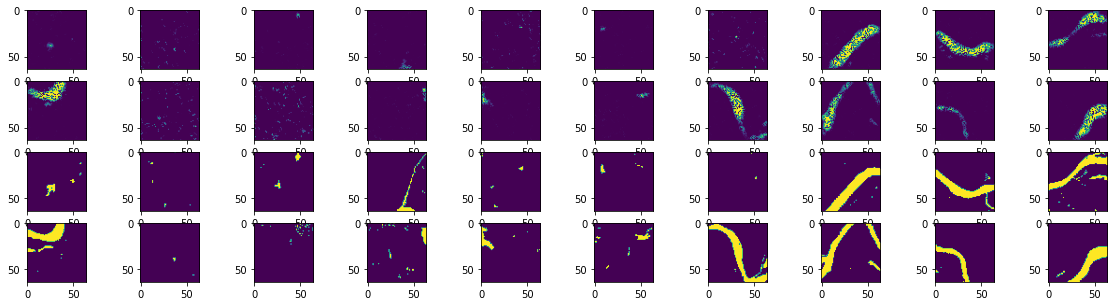

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.


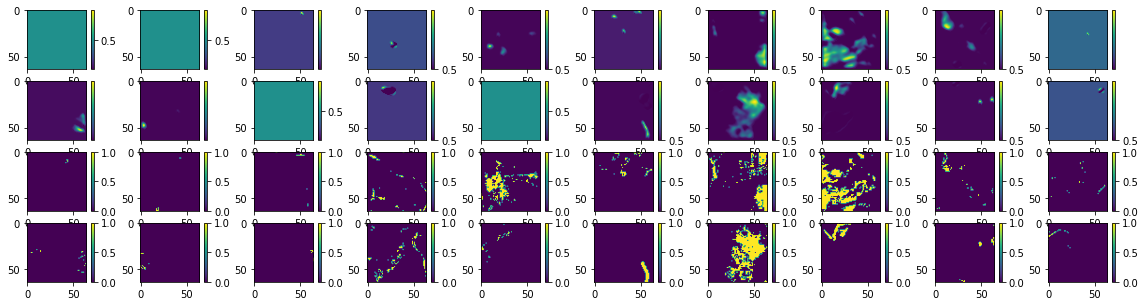

0,0.7374711632728577,0
epoch- 1 batch_num- 0 / 75
epoch- 1 batch_num- 1 / 75
epoch- 1 batch_num- 2 / 75
epoch- 1 batch_num- 3 / 75
epoch- 1 batch_num- 4 / 75
epoch- 1 batch_num- 5 / 75
epoch- 1 batch_num- 6 / 75
epoch- 1 batch_num- 7 / 75
epoch- 1 batch_num- 8 / 75
epoch- 1 batch_num- 9 / 75
epoch- 1 batch_num- 10 / 75
epoch- 1 batch_num- 11 / 75
epoch- 1 batch_num- 12 / 75
epoch- 1 batch_num- 13 / 75
epoch- 1 batch_num- 14 / 75
epoch- 1 batch_num- 15 / 75
epoch- 1 batch_num- 16 / 75
epoch- 1 batch_num- 17 / 75
epoch- 1 batch_num- 18 / 75
epoch- 1 batch_num- 19 / 75
epoch- 1 batch_num- 20 / 75
epoch- 1 batch_num- 21 / 75
epoch- 1 batch_num- 22 / 75
epoch- 1 batch_num- 23 / 75
epoch- 1 batch_num- 24 / 75
epoch- 1 batch_num- 25 / 75
epoch- 1 batch_num- 26 / 75
epoch- 1 batch_num- 27 / 75
epoch- 1 batch_num- 28 / 75
epoch- 1 batch_num- 29 / 75
epoch- 1 batch_num- 30 / 75
epoch- 1 batch_num- 31 / 75
epoch- 1 batch_num- 32 / 75
epoch- 1 batch_num- 33 / 75
epoch- 1 batch_num- 34 / 75
epoch- 

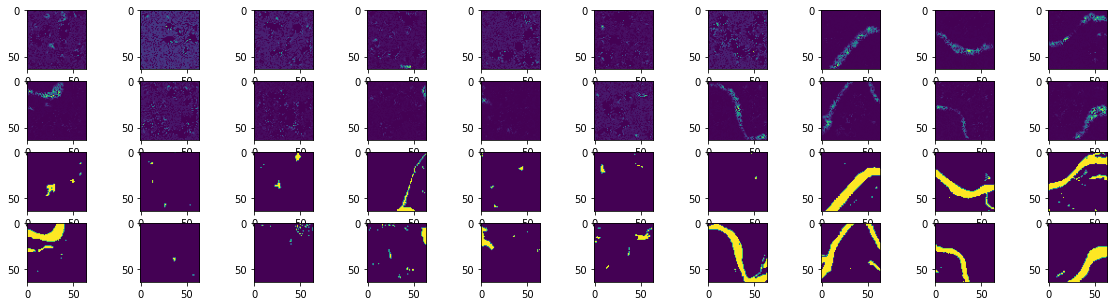

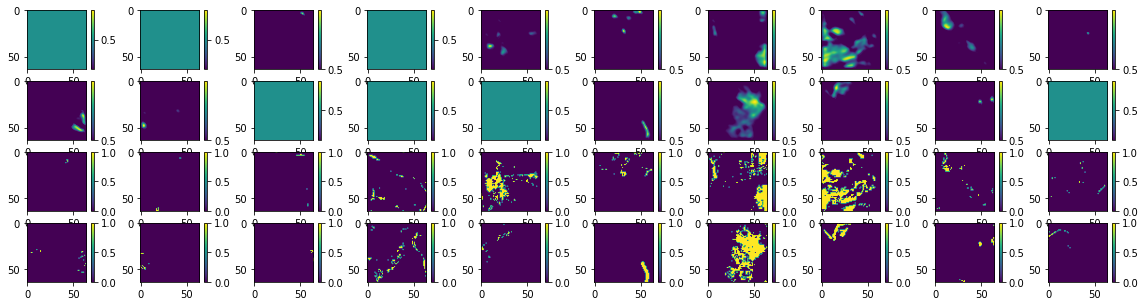

1,0.7020940184593201,0
epoch- 2 batch_num- 0 / 75
epoch- 2 batch_num- 1 / 75
epoch- 2 batch_num- 2 / 75
epoch- 2 batch_num- 3 / 75
epoch- 2 batch_num- 4 / 75
epoch- 2 batch_num- 5 / 75
epoch- 2 batch_num- 6 / 75
epoch- 2 batch_num- 7 / 75
epoch- 2 batch_num- 8 / 75
epoch- 2 batch_num- 9 / 75
epoch- 2 batch_num- 10 / 75
epoch- 2 batch_num- 11 / 75
epoch- 2 batch_num- 12 / 75
epoch- 2 batch_num- 13 / 75
epoch- 2 batch_num- 14 / 75
epoch- 2 batch_num- 15 / 75
epoch- 2 batch_num- 16 / 75
epoch- 2 batch_num- 17 / 75
epoch- 2 batch_num- 18 / 75
epoch- 2 batch_num- 19 / 75
epoch- 2 batch_num- 20 / 75
epoch- 2 batch_num- 21 / 75
epoch- 2 batch_num- 22 / 75
epoch- 2 batch_num- 23 / 75
epoch- 2 batch_num- 24 / 75
epoch- 2 batch_num- 25 / 75
epoch- 2 batch_num- 26 / 75
epoch- 2 batch_num- 27 / 75
epoch- 2 batch_num- 28 / 75
epoch- 2 batch_num- 29 / 75
epoch- 2 batch_num- 30 / 75
epoch- 2 batch_num- 31 / 75
epoch- 2 batch_num- 32 / 75
epoch- 2 batch_num- 33 / 75
epoch- 2 batch_num- 34 / 75
epoch- 

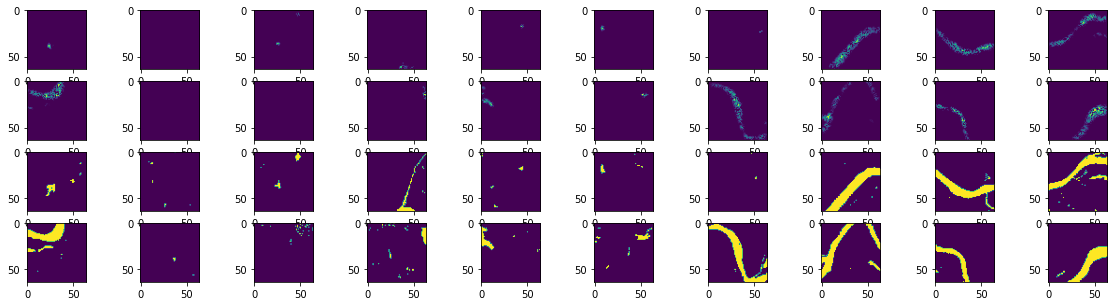

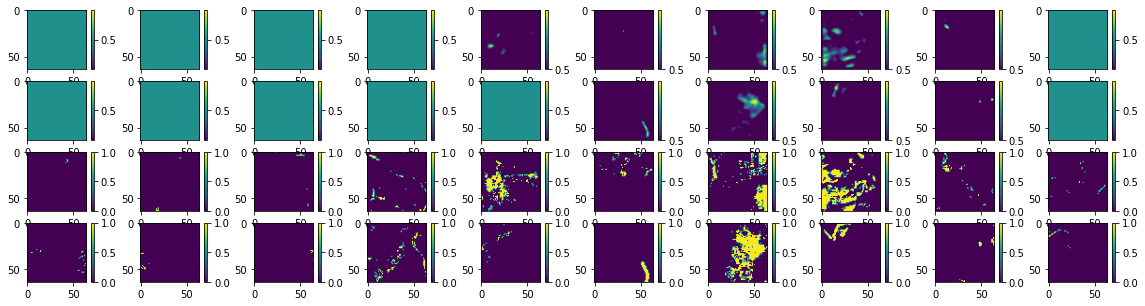

2,0.6927017569541931,0
epoch- 3 batch_num- 0 / 75
epoch- 3 batch_num- 1 / 75
epoch- 3 batch_num- 2 / 75
epoch- 3 batch_num- 3 / 75
epoch- 3 batch_num- 4 / 75
epoch- 3 batch_num- 5 / 75
epoch- 3 batch_num- 6 / 75
epoch- 3 batch_num- 7 / 75
epoch- 3 batch_num- 8 / 75
epoch- 3 batch_num- 9 / 75
epoch- 3 batch_num- 10 / 75
epoch- 3 batch_num- 11 / 75
epoch- 3 batch_num- 12 / 75
epoch- 3 batch_num- 13 / 75
epoch- 3 batch_num- 14 / 75
epoch- 3 batch_num- 15 / 75
epoch- 3 batch_num- 16 / 75
epoch- 3 batch_num- 17 / 75
epoch- 3 batch_num- 18 / 75
epoch- 3 batch_num- 19 / 75
epoch- 3 batch_num- 20 / 75
epoch- 3 batch_num- 21 / 75
epoch- 3 batch_num- 22 / 75
epoch- 3 batch_num- 23 / 75
epoch- 3 batch_num- 24 / 75
epoch- 3 batch_num- 25 / 75
epoch- 3 batch_num- 26 / 75
epoch- 3 batch_num- 27 / 75
epoch- 3 batch_num- 28 / 75
epoch- 3 batch_num- 29 / 75
epoch- 3 batch_num- 30 / 75
epoch- 3 batch_num- 31 / 75
epoch- 3 batch_num- 32 / 75
epoch- 3 batch_num- 33 / 75
epoch- 3 batch_num- 34 / 75
epoch- 

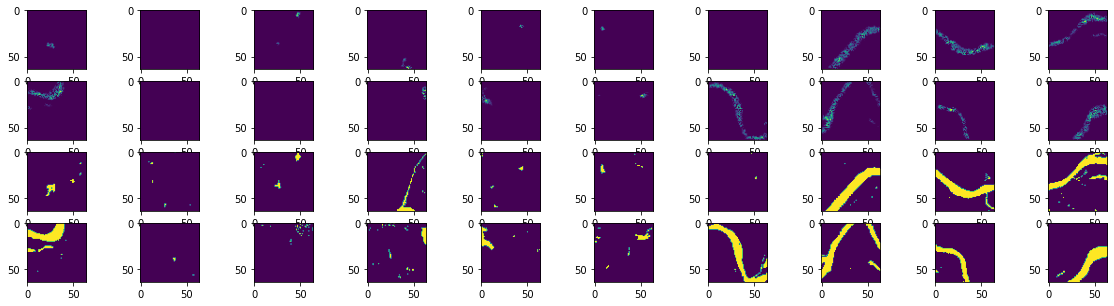

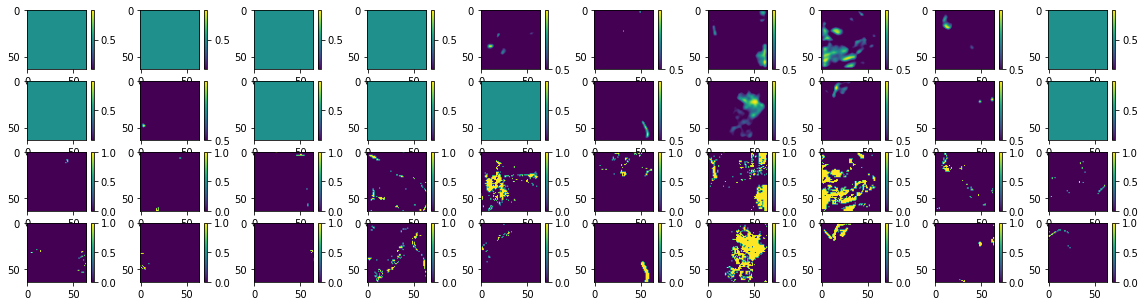

3,0.6916072964668274,0
epoch- 4 batch_num- 0 / 75
epoch- 4 batch_num- 1 / 75
epoch- 4 batch_num- 2 / 75
epoch- 4 batch_num- 3 / 75
epoch- 4 batch_num- 4 / 75
epoch- 4 batch_num- 5 / 75
epoch- 4 batch_num- 6 / 75
epoch- 4 batch_num- 7 / 75
epoch- 4 batch_num- 8 / 75
epoch- 4 batch_num- 9 / 75
epoch- 4 batch_num- 10 / 75
epoch- 4 batch_num- 11 / 75
epoch- 4 batch_num- 12 / 75
epoch- 4 batch_num- 13 / 75
epoch- 4 batch_num- 14 / 75
epoch- 4 batch_num- 15 / 75
epoch- 4 batch_num- 16 / 75
epoch- 4 batch_num- 17 / 75
epoch- 4 batch_num- 18 / 75
epoch- 4 batch_num- 19 / 75
epoch- 4 batch_num- 20 / 75
epoch- 4 batch_num- 21 / 75
epoch- 4 batch_num- 22 / 75
epoch- 4 batch_num- 23 / 75
epoch- 4 batch_num- 24 / 75
epoch- 4 batch_num- 25 / 75
epoch- 4 batch_num- 26 / 75
epoch- 4 batch_num- 27 / 75
epoch- 4 batch_num- 28 / 75
epoch- 4 batch_num- 29 / 75
epoch- 4 batch_num- 30 / 75
epoch- 4 batch_num- 31 / 75
epoch- 4 batch_num- 32 / 75
epoch- 4 batch_num- 33 / 75
epoch- 4 batch_num- 34 / 75
epoch- 

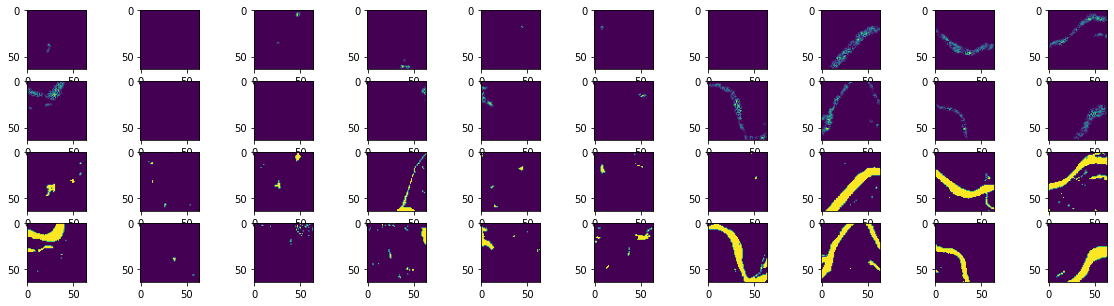

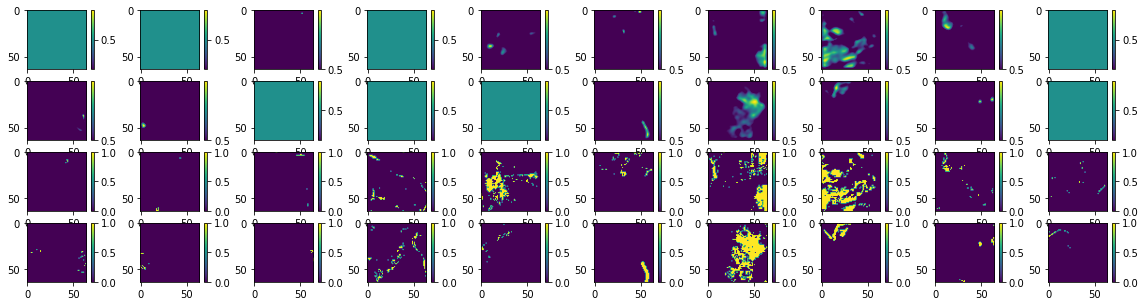

4,0.6928004622459412,0


In [14]:
for epoch in range(5):
    model.train()
    loss_vector = torch.zeros(n_batches, dtype=torch.float)
    for index in range(n_batches):
      optimizer.zero_grad()
      print("epoch-", epoch, "batch_num-", index, "/", n_batches)
      y_pred = model(train_set_x[index*400:(index+1)*400])

      #y_pred = torch.where(y_pred > 0.5, 1.0, 0.0).to(device)
      #y_pred" = Variable(y_pred.data, requires_grad=True)

      y_train = train_set_y[index*400:(index+1)*400]

      loss = loss_function(y_pred, torch.reshape(train_set_y[index*400:(index+1)*400], y_pred.size()))
      loss.backward()
      loss_vector[index] = loss
      optimizer.step()
      

    fig = plt.figure(figsize = (20, 5)) 
    rows = 4
    cols = 10
    o = 1
    for n in range(40):
        if n < 20:
          img = y_pred[n].detach().cpu().numpy().reshape(64, 64)
          ax = fig.add_subplot(rows, cols, o)
          im= ax.imshow(img)

        else:
          img = y_train[n-20].detach().cpu().numpy().reshape(64, 64)
          ax = fig.add_subplot(rows, cols, o)
          im= ax.imshow(img)

        #cbar = plt.colorbar(im, ticks=[0, 0.5, 0.55, 0.6, 1.0])
        #cbar.set_clim(0.4, 0.7)
        o += 1
    plt.show()

    model.eval()
    ACC = 0

    for index_test in range(n_batches_test):
      y_pred_eval = model(test_set_x[index_test*400:(index_test+1)*400, :, :, :]).detach().cpu().numpy()
      #y_pred_eval = np.where(y_pred_eval > 0.5, 1, 0).reshape(-1, 1)
      y_test_eval = test_set_y[index_test*400:(index_test+1)*400, :, :].detach().cpu().numpy()
      #y_train_eval = y_train_eval.reshape(-1, 1)
      #ACC += accuracy_score(y_pred_eval, y_train_eval)
      break


    fig = plt.figure(figsize = (20, 5)) 
    rows = 4
    cols = 10
    o = 1
    for n in range(40):
        if n < 20:
          img = y_pred_eval[n].reshape(64, 64)
          ax = fig.add_subplot(rows, cols, o)
          im= ax.imshow(img)

        else:
          img = y_test_eval[n-20].reshape(64, 64)
          ax = fig.add_subplot(rows, cols, o)
          im= ax.imshow(img)

        cbar = plt.colorbar(im, ticks=[0, 0.5, 1.0])
        cbar.set_clim(0, 1)
        o += 1
    plt.show()

    print("{},{},{}".format(epoch, torch.mean(loss_vector), ACC))
    gc.collect()

In [15]:
input_list = glob.glob("/content/drive/MyDrive/Detection_river/sentinel/*.tif")
output_list = glob.glob("/content/drive/MyDrive/Detection_river/label/*.tif")

0.52813363 0.5


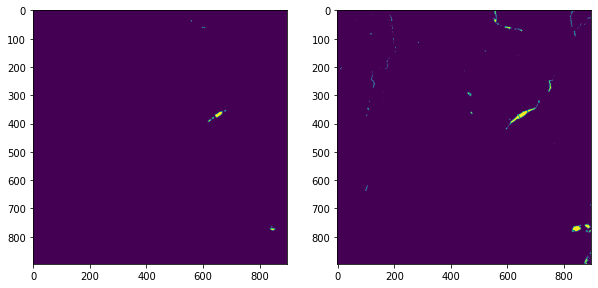

0.6293548 0.5


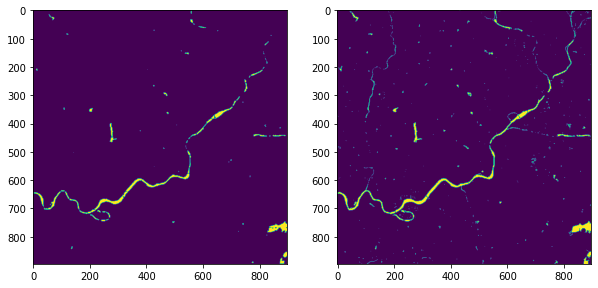

0.58019215 0.5


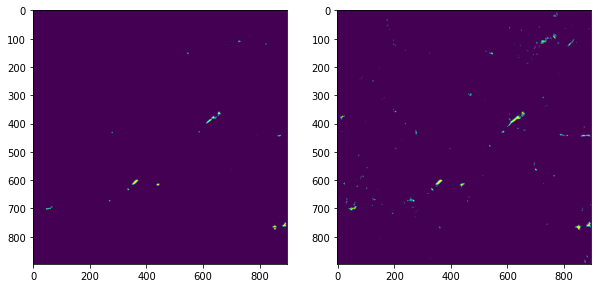

0.6314554 0.5


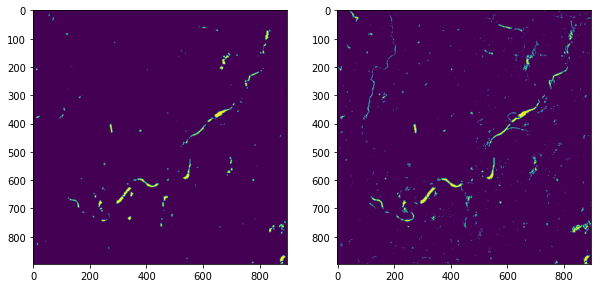

0.5 0.5


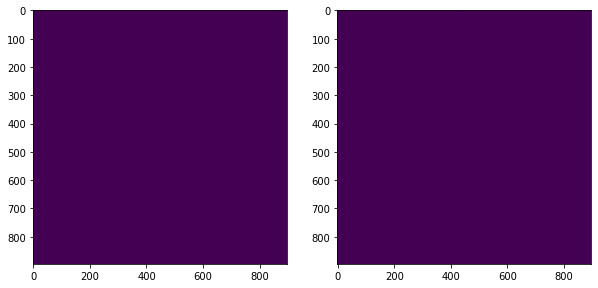

0.5 0.5


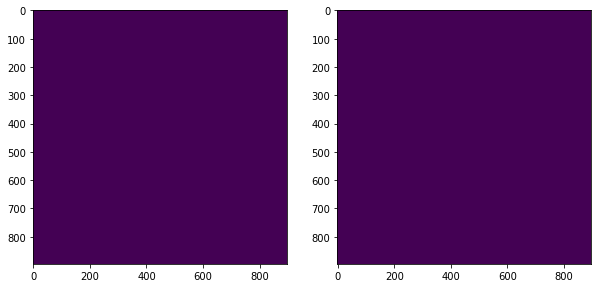

0.680903 0.5


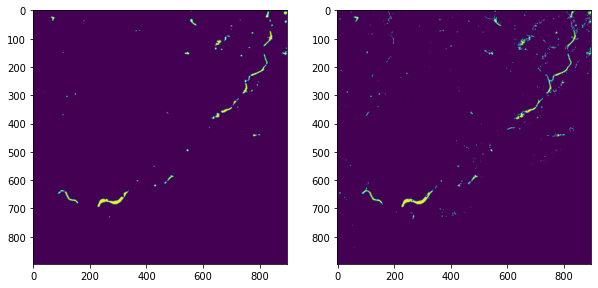

0.6474024 0.5


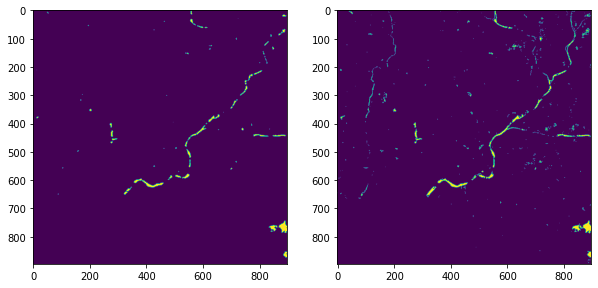

0.6682777 0.5


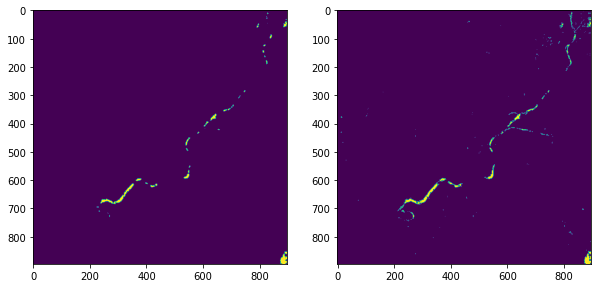

0.5 0.5


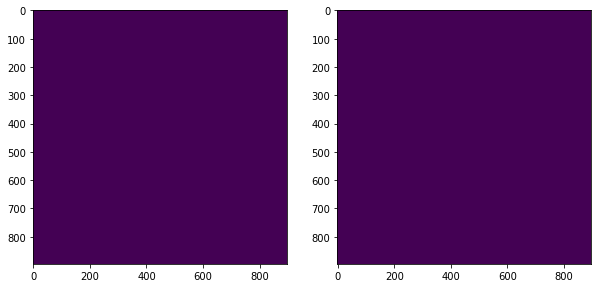

0.51030385 0.5


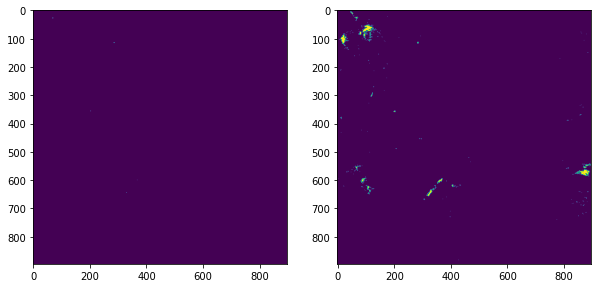

0.5 0.5


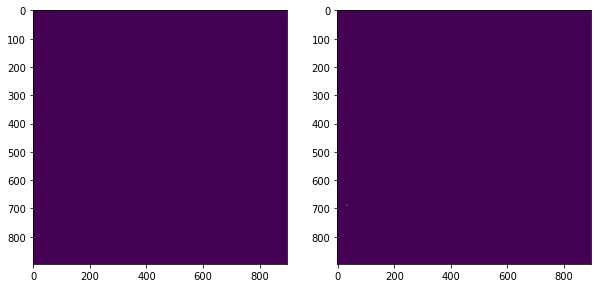

0.6409272 0.5


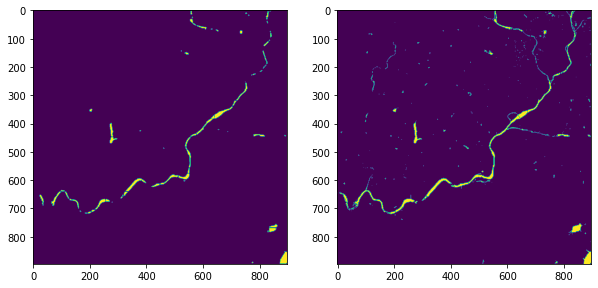

0.6434086 0.5


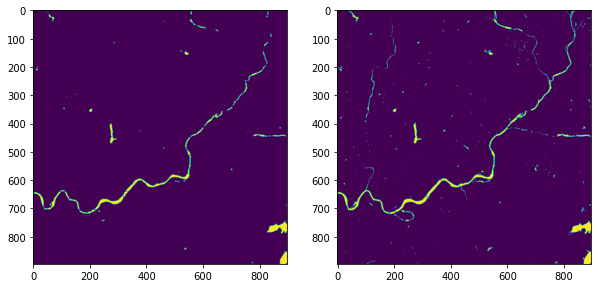

0.5812671 0.5


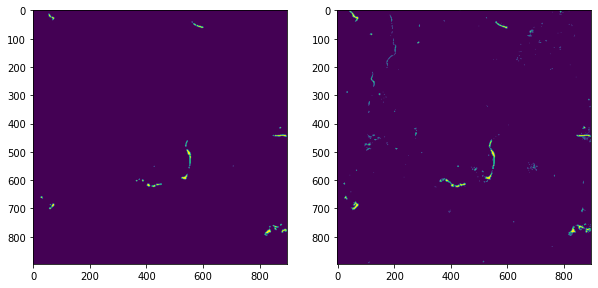

0.6654333 0.5


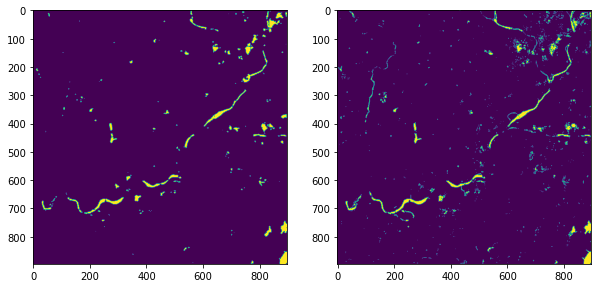

0.6335534 0.5


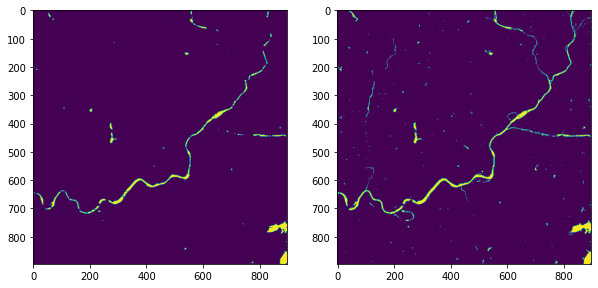

0.5 0.5


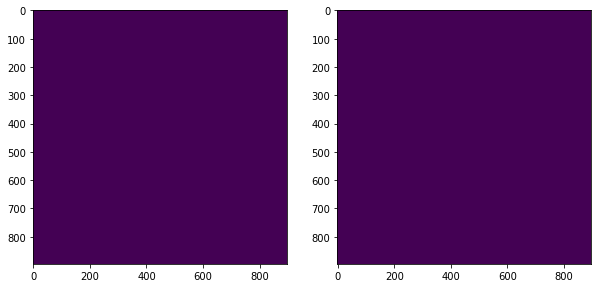

0.6797452 0.5


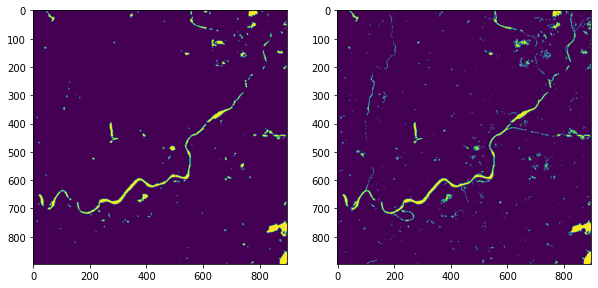

0.5976973 0.5


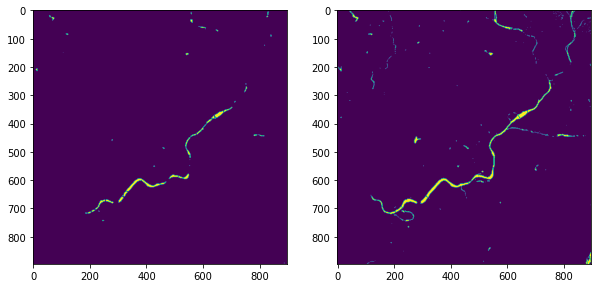

0.6291277 0.5


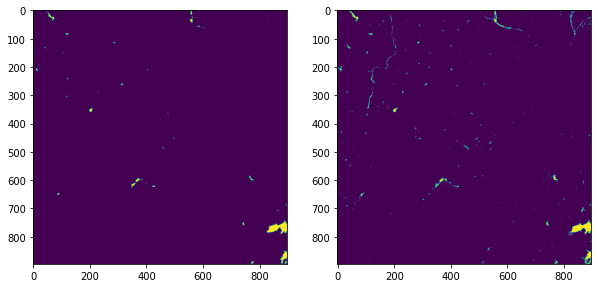

0.6301268 0.5


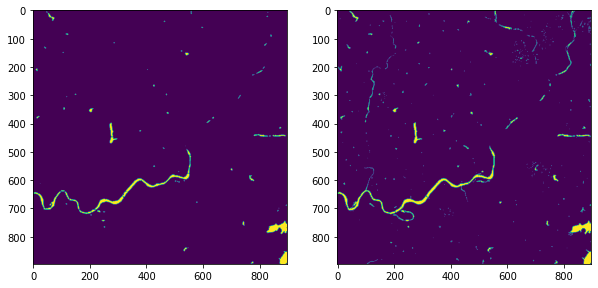

0.5 0.5


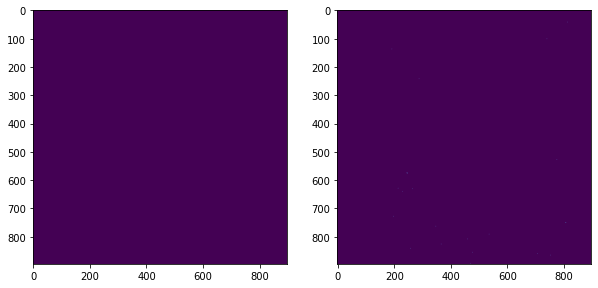

0.6307537 0.5


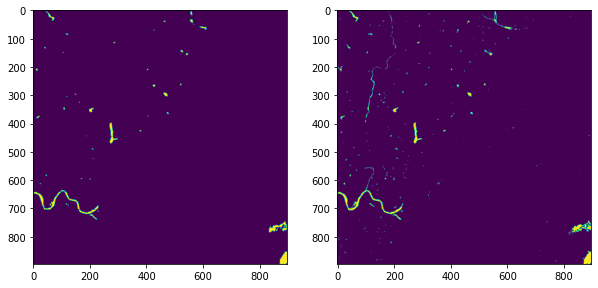

0.5 0.5


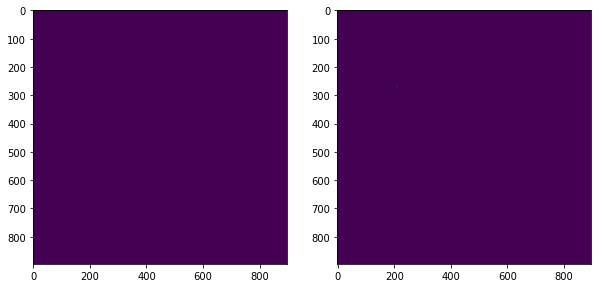

0.5380846 0.5


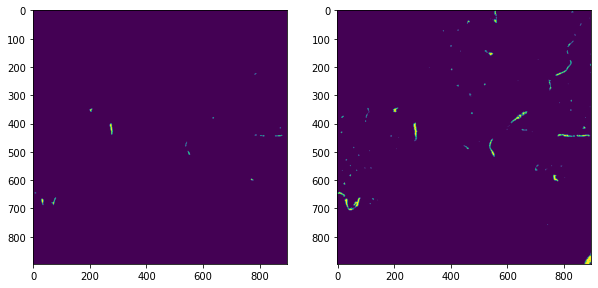

0.65103424 0.5


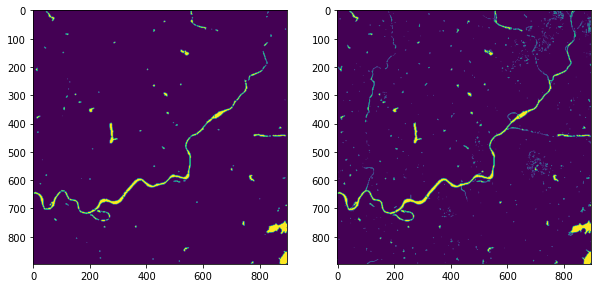

0.64002043 0.5


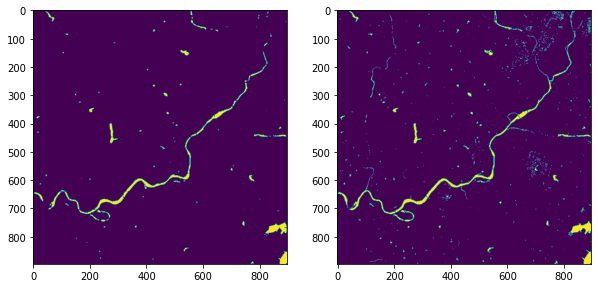

0.6378677 0.5


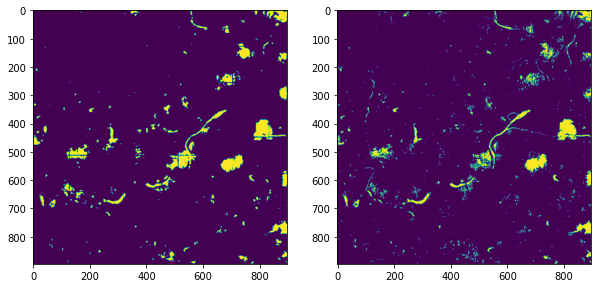

0.6071297 0.5


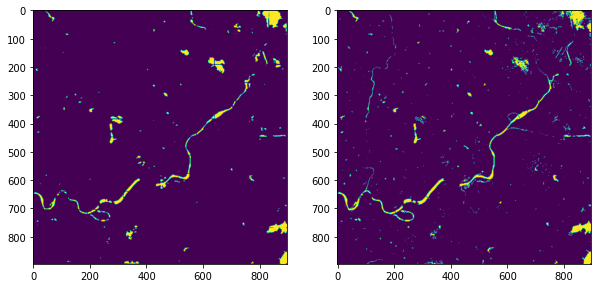

0.6295084 0.5


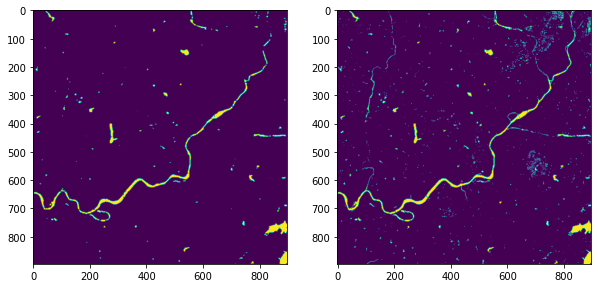

0.6342755 0.5


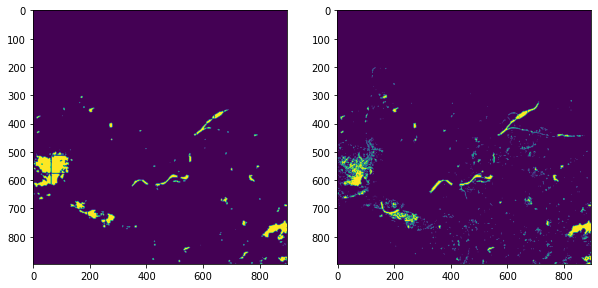

0.5 0.5


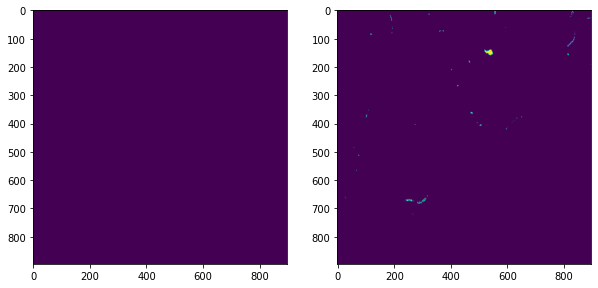

0.56337273 0.5


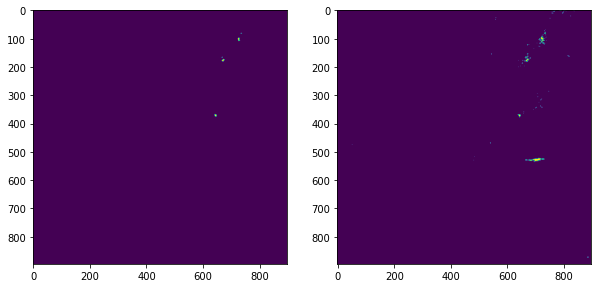

0.63947433 0.5


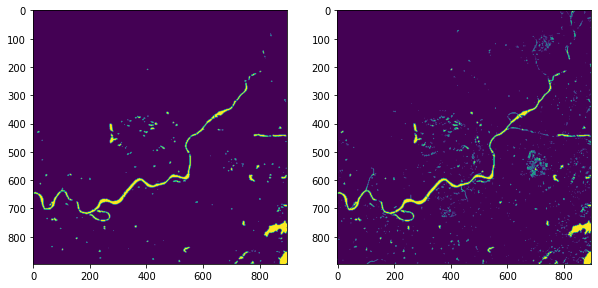

0.6440828 0.5


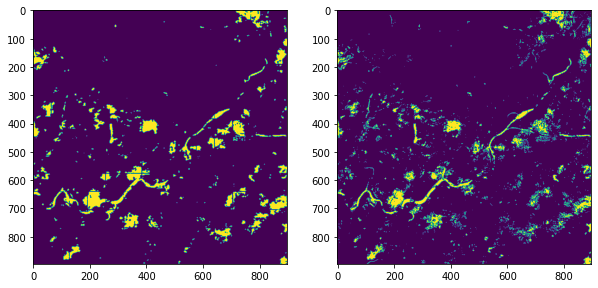

0.58871526 0.5


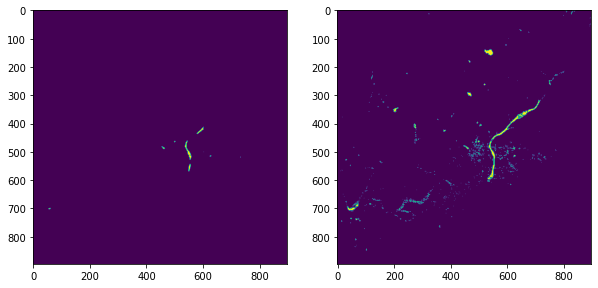

0.6167011 0.5


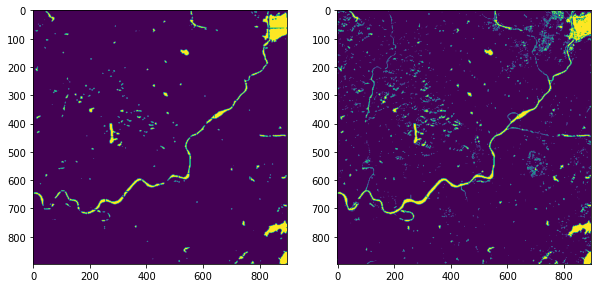

0.5 0.5


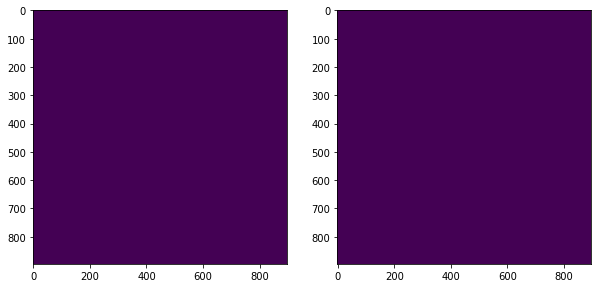

0.6588373 0.5


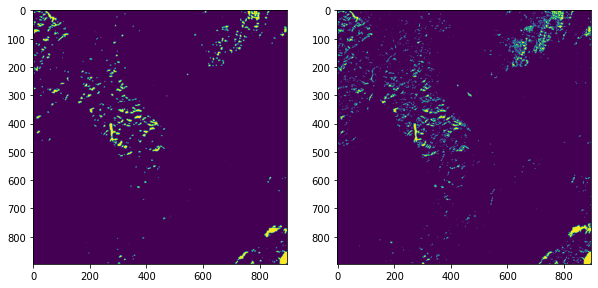

0.680545 0.5


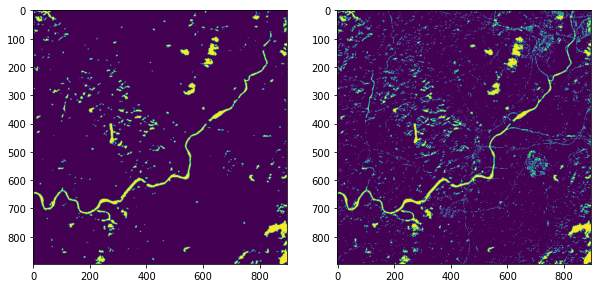

0.5 0.5


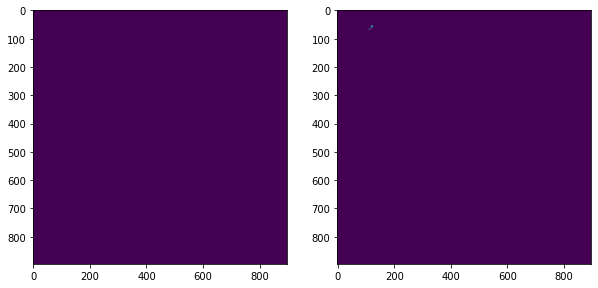

0.64821726 0.5


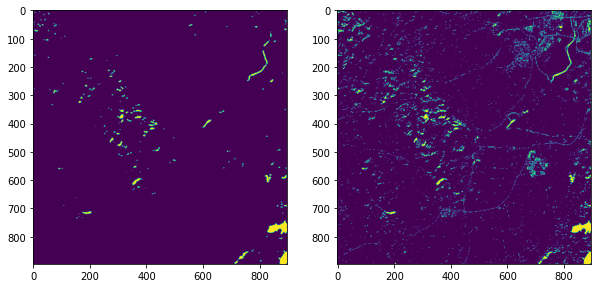

0.649498 0.5


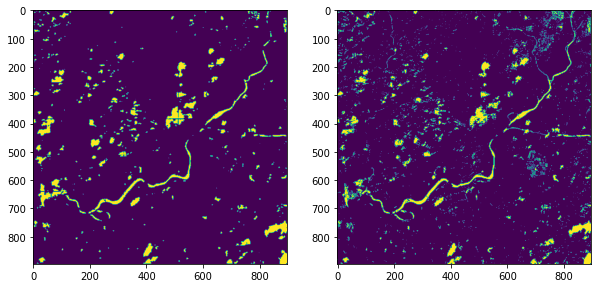

0.5 0.5


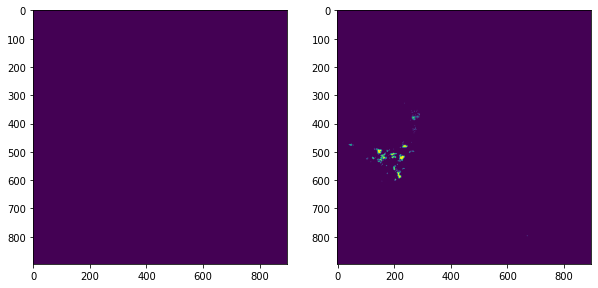

0.65365 0.5


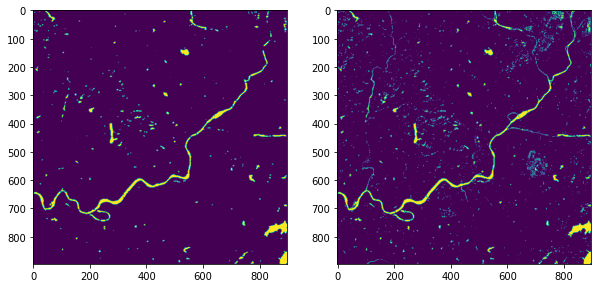

0.5 0.5


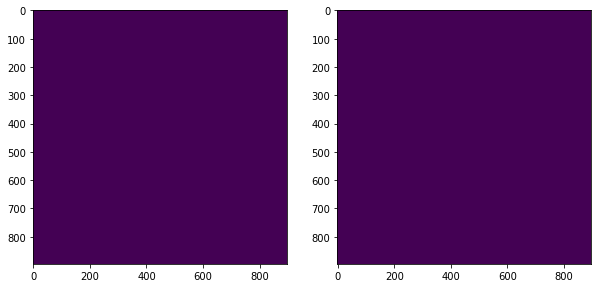

0.56550086 0.5


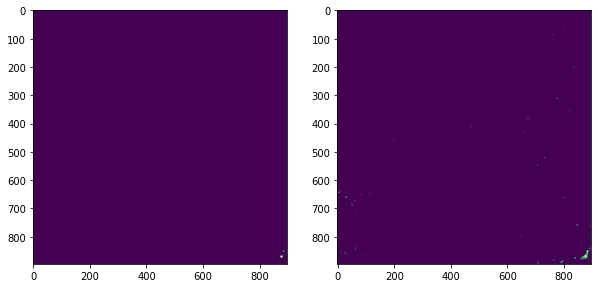

0.5 0.5


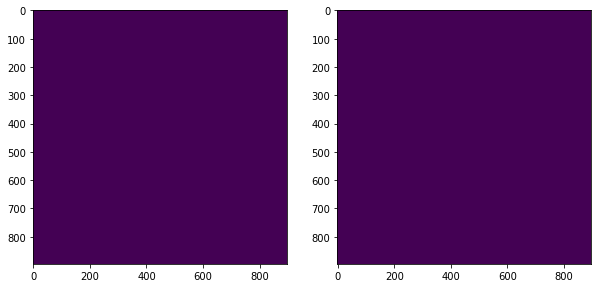

0.63615507 0.5


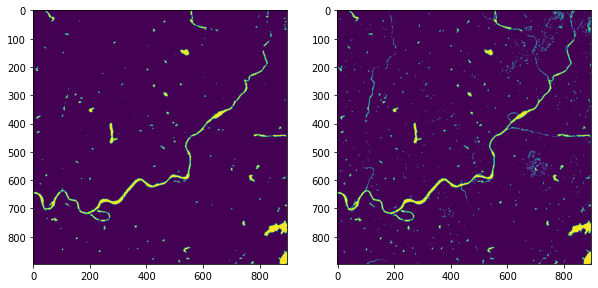

In [16]:
model.eval()

for i in range(250,300):
  input_image = rio.open(input_list[i]).read()[:13, :897, :897]
  input_image = input_image.reshape(1, 13, 897, 897).astype("float32")
  output_image = input_image.copy()[:, -1, :, :].reshape(1, 1, 897, 897)
  output_image = output_image[:, :, :896, :896].reshape(896, 896).astype("float32")
  mean =  np.array(mean).astype("float32")
  std = np.array(std).astype("float32")

  band_3 = input_image[:, 2, :, :].reshape(-1, 1)
  band_7 = input_image[:, 7, :, :].reshape(-1, 1)
  NDWI =  (band_3 - band_7)/(band_3 + band_7)
  NDWI = np.where(NDWI > 0.04, 100, 0)
  NDWI = NDWI.reshape(1, 1, 897, 897)
  NDWI = NDWI[:, :, :896, :896]

  for i in range(0, 13):
    input_image[:, i:i+1, :, :] = (input_image[:, i:i+1, :, :] - mean[i])/std[i]

  rip_size = 64
  for n_x in range(0, 14):
    rip_x = input_image[:, :, rip_size*n_x:rip_size*(n_x+1), :]
    for n_y in range(0, 14):
      rip_xy = rip_x[:, :, :, n_y*rip_size:rip_size*(n_y+1)]
      rip_xy = rip_xy.astype("float32")
      #print(rip_xy)
      model_output = model(torch.Tensor(rip_xy).to(device))
      #print(model_output)
      output_image[rip_size*n_x:rip_size*(n_x+1), n_y*rip_size:rip_size*(n_y+1)] = model_output.detach().cpu().numpy().astype("float32").reshape(64, 64)
      #print(output_image[rip_size*n_x:rip_size*(n_x+1), n_y*rip_size:rip_size*(n_y+1)])
      #print(np.max(output_image[rip_size*n_x:rip_size*(n_x+1), n_y*rip_size:rip_size*(n_y+1)]), np.min(output_image[rip_size*n_x:rip_size*(n_x+1), n_y*rip_size:rip_size*(n_y+1)]))

  fig = plt.figure(figsize = (10, 5)) 
  rows = 1
  cols = 2
  o = 1
  print(np.max(output_image), np.min(output_image))
  for n in range(2):
      if n < 1:
        img = np.where(output_image > 0.5, 1, 0)
        ax = fig.add_subplot(rows, cols, o)
        im= ax.imshow(img)

      else:
        img = NDWI.reshape(896, 896)
        ax = fig.add_subplot(rows, cols, o)
        im= ax.imshow(img)

      #cbar = plt.colorbar(im, ticks=[0, 0.5, 0.55, 0.6, 1.0])
      #cbar.set_clim(0.4, 0.7)
      o += 1
  plt.show()

#  print(np.max(output_image), np.min(output_image))
#  fig = plt.figure(figsize = (20, 10)) 
#  img = output_image
#  ax = fig.add_subplot()
#  im= ax.imshow(img)
#  #cbar = plt.colorbar(im, ticks=[0, 0.5, 1.0])
#  #cbar.set_clim(0, 1)
#  plt.show()

